## Convolutional Neural Network for Malicious Traffic

Written by Zachary Fagnou

Trained on data extracted from Wireshark during normal activity, and while being attacked by various attack types. 

Used at a small scale in conjunciton with Open5gs.

Training data has not been included as it is under NDA.

In [1]:
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install scikit-learn

In [2]:
!pip install tensorflow-metal

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import re
from tensorflow.keras.callbacks import EarlyStopping

# Extra Functions

In [4]:
def extract_values(text):
    
    parts = text.split('=')
    
    results = {'Standard Query' : 0,
                'Name Query' : 0,
                'TCP Transmission' : 0,
                'Application Data' : 0,
                'Seq' : 0,
                'Ack' : 0,
                'Win' : 0,
                'Len' : 0,
                'TSval' : 0,
                'TSecr' : 0,
                'Source_Port' : 0,
                'Destination_Port' : 0,
                'TCP Dup ACK' : 0,
                'Who Has' : 0,
                }
    # Check for Who has in the text
    if 'Who has' in text:
        results['Who has'] = 1
        
    # Check for TCP Dup ACK in the text
    if 'TCP Dup ACK' in text:
        results['TCP Dup ACK'] = 1
    
    # Check for Standard Query in the text
    if 'Standard Query' in text:
        results['Standard Query'] = 1
    
    # Check for Name Query in the text
    if 'Name query' in text:
        results['Name Query'] = 1
    
    # Check for [TCP Retransmission] in the text
    if '[TCP Retransmission]' in text:
        results['TCP Retransmission'] = 1
    
    # Check for Application Data in the text
    if 'Application Data' in text:
        results['Application Data'] = 1
    
    
    for i in range(len(parts) - 1):
        # Get the segment before '=' and split by space, then take the last part
        before = parts[i].rsplit(' ', 1)[-1]
        
        # Get the segment after '=' and split by space, then take the first part
        after = parts[i + 1].split(' ', 1)[0]
        
        results[before] = after
        
    # Find all matches for 'number > number' pattern
    pattern = re.compile(r'(\d+)\s*>\s*(\d+)')
    matches = pattern.findall(text)
    
    for match in matches:
        source_port = int(match[0])
        destination_port = int(match[1])
        results['Source_Port'] = source_port
        results['Destination_Port'] = destination_port
    
    
    return results


test = '443  >  57564 [ACK] Seq=1 Ack=1 Win=8 Len=1134 TSval=4226585851 TSecr=1528951308 [TCP segment of a reassembled PDU]'
extract_values(test)

{'Standard Query': 0,
 'Name Query': 0,
 'TCP Transmission': 0,
 'Application Data': 0,
 'Seq': '1',
 'Ack': '1',
 'Win': '8',
 'Len': '1134',
 'TSval': '4226585851',
 'TSecr': '1528951308',
 'Source_Port': 443,
 'Destination_Port': 57564,
 'TCP Dup ACK': 0,
 'Who Has': 0}

# Cleaning

In [5]:
def clean_data(X):
    # Remove all rows with "Broadcast" in them
    X = X[~(X == "Broadcast").any(axis=1)]

    # Remove all IPV6 Rows
    mask_source = X["Source"].apply(lambda x: ':' in str(x))
    mask_dest = X["Destination"].apply(lambda x: ':' in str(x))
    mask = mask_source | mask_dest

    X = X[~mask]
    
    print("----------")

    # Separates Source to more easily modify
    X_source = X.iloc[0:,2].values

    X_source = X_source.tolist()
    n = len(X_source)
    
    print(">---------")
    
    X_source_div = [0]*n
    X_source_IP = [0]*n
    
    print(">>--------")

    # Removes all but device of source
    for i in range(n):
        
        X_source[i] = X_source[i].split(".")
        X_source_div[i] = X_source[i][2]
        
        X_source_IP[i] = X_source[i][0:2]
        X_source_IP[i] = "".join(X_source_IP[i])

    print(">>>-------")
    
    X["Source Device"] = X_source_div
    X["Source IP"] = X_source_IP
    
    print(">>>>------")

    # Separates Destination to more easily modify
    X_dest = X.iloc[0:,3].values

    X_dest = X_dest.tolist()
    n = len(X_dest)
    
    print(">>>>>-----")

    X_dest_div = [0]*n
    X_dest_IP = [0]*n

    # Removes all but device of destination
    for i in range(n):
        
        X_dest[i] = X_dest[i].split(".")
        X_dest_div[i] = X_dest[i][3]
        
        X_dest_IP[i] = X_dest[i][0:3]
        X_dest_IP[i] = "".join(X_dest_IP[i])
        
    print(">>>>>>----")

    X["Destination Device"] = X_dest_div
    X["Destination IP"] = X_dest_IP
    
    print(">>>>>>>---")

    X.drop(X.columns[3], axis=1, inplace=True)
    X.drop(X.columns[2], axis=1, inplace=True)
    
    print(">>>>>>>>--")
    
    # Cleaning Info Column :`(

    X_info = X.iloc[0:,4].values
    X_info = X_info.tolist()
    n = len(X_info)

    print(">>>>>>>>>-")
    for i in range(n):
        dictionary = extract_values(X_info[i])
        info = [i, [[key, value] for key, value in dictionary.items()]]
        
        X['Standard Query'] = info[1][0][1]
        X['Name Query'] = info[1][1][1]
        X['TCP Transmission'] = info[1][2][1]
        X['Application Data'] = info[1][3][1]
        X['Seq'] = info[1][4][1]
        X['Ack'] = info[1][5][1]
        X['Win'] = info[1][6][1]
        X['Len'] = info[1][7][1]
        X['TSval'] = info[1][8][1]
        X['TSecr'] = info[1][9][1]
        X['Source_Port'] = info[1][10][1]
        X['Destination_Port'] = info[1][11][1]
        X['TCP Dup ACK'] = info[1][12][1]
        X['Who Has'] = info[1][13][1]

    print(">>>>>>>>>>")
    X.drop(['Info'], axis=1, inplace=True)
    X.drop(['No.'], axis=1, inplace=True)
    X.drop(['Time'], axis=1, inplace=True)
    
    # Used for testing categories
    
    # X.drop(['Source IP'], axis=1, inplace=True)
    # X.drop(['Destination IP'], axis=1, inplace=True)
    # X.drop(['Source Device'], axis=1, inplace=True)
    # X.drop(['Destination Device'], axis=1, inplace=True)
    # X.drop(['Source_Port'], axis=1, inplace=True)
    # X.drop(['Destination_Port'], axis=1, inplace=True)
    # X.drop(['Seq'], axis=1, inplace=True)
    # X.drop(['Ack'], axis=1, inplace=True)
    # X.drop(['Win'], axis=1, inplace=True)
    # X.drop(['Len'], axis=1, inplace=True)
    # X.drop(['TSval'], axis=1, inplace=True)
    # X.drop(['TSecr'], axis=1, inplace=True)
    # X.drop(['TCP Dup ACK'], axis=1, inplace=True)
    # X.drop(['Who Has'], axis=1, inplace=True)
    # X.drop(['Standard Query'], axis=1, inplace=True)
    # X.drop(['Name Query'], axis=1, inplace=True)
    # X.drop(['TCP Transmission'], axis=1, inplace=True)
    # X.drop(['Application Data'], axis=1, inplace=True)

    return X

        


In [6]:
X3 = pd.read_csv('training_data/sctp_attack.csv', encoding='utf-8', low_memory=False)
X3 = clean_data(X3)
X3.head()

----------
>---------
>>--------
>>>-------
>>>>------
>>>>>-----
>>>>>>----
>>>>>>>---
>>>>>>>>--
>>>>>>>>>-
>>>>>>>>>>


,Protocol,Length,Source Device,Source IP,Destination Device,Destination IP,Standard Query,Name Query,TCP Transmission,Application Data,Seq,Ack,Win,Len,TSval,TSecr,Source_Port,Destination_Port,TCP Dup ACK,Who Has
0,TCP,60,243,34107,5,1002,0,0,0,0,0,0,64240,0,885268306,0,58560,80,0,0
1,TCP,54,2,100,108,192229211,0,0,0,0,0,0,64240,0,885268306,0,58560,80,0,0
2,TCP,54,2,100,108,192229211,0,0,0,0,0,0,64240,0,885268306,0,58560,80,0,0
3,TCP,54,2,100,108,192229211,0,0,0,0,0,0,64240,0,885268306,0,58560,80,0,0
4,TCP,60,211,192229,5,1002,0,0,0,0,0,0,64240,0,885268306,0,58560,80,0,0


In [7]:
# Cleaning and concatonating training data

X0 = pd.read_csv('training_data/NormalData.csv', encoding='utf-8', low_memory=False)

X1 = pd.read_csv('training_data/DOSATTACK.csv', encoding='utf-8', low_memory=False)

X2 = pd.read_csv('training_data/amf-GW.csv', encoding='utf-8', low_memory=False)

X3 = pd.read_csv('training_data/sctp_attack.csv', encoding='utf-8', low_memory=False)

X1 = X1.drop([i for i in range(50000, len(X1))])
X2 = X2.drop([i for i in range(50000, len(X2))])

print("Beginning Cleaning Normal Data")
X0 = clean_data(X0)
print("Finished Cleaning Normal Data")

print("Beginning Cleaning DOS Attack Data")
X1 = clean_data(X1)
print("Finished Cleaning DOS Attack Data")

print("Beginning Cleaning amf-GW Data")
X2 = clean_data(X2)
print("Finished Cleaning amf-GW Data")

print("Beginning Cleaning SCTP Attack Data")
X3 = clean_data(X3)
print("Finished Cleaning SCTP Attack Data")


X = pd.concat([X0, X1, X2, X3])

X.to_numpy()

print("Constructing y values")
y = []
for i in range(len(X0)):
    y.append(0)
for i in range(len(X1)):
    y.append(1)
for i in range(len(X2)):
    y.append(1)
for i in range(len(X3)):
    y.append(1)
print("Finished Constructing y values")

y = np.array(y)

# Saves training data to numpy files
np.save('X.npy', X)
np.save('y.npy', y)


Beginning Cleaning Normal Data
----------
>---------
>>--------
>>>-------
>>>>------
>>>>>-----
>>>>>>----
>>>>>>>---
>>>>>>>>--
>>>>>>>>>-
>>>>>>>>>>
Finished Cleaning Normal Data
Beginning Cleaning DOS Attack Data
----------
>---------
>>--------
>>>-------
>>>>------
>>>>>-----
>>>>>>----
>>>>>>>---
>>>>>>>>--
>>>>>>>>>-
>>>>>>>>>>
Finished Cleaning DOS Attack Data
Beginning Cleaning amf-GW Data
----------
>---------
>>--------
>>>-------
>>>>------
>>>>>-----
>>>>>>----
>>>>>>>---
>>>>>>>>--
>>>>>>>>>-
>>>>>>>>>>
Finished Cleaning amf-GW Data
Beginning Cleaning SCTP Attack Data
----------
>---------
>>--------
>>>-------
>>>>------
>>>>>-----
>>>>>>----
>>>>>>>---
>>>>>>>>--
>>>>>>>>>-
>>>>>>>>>>
Finished Cleaning SCTP Attack Data
Constructing y values
Finished Constructing y values


# Feature Scaling

In [8]:
X = np.load('X.npy', allow_pickle=True)
y = np.load('y.npy', allow_pickle=True)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
X_train[0:, 0]

array(['UDP', 'SCTP', 'UDP', ..., 'PFCP', 'TCP', 'SCTP'], dtype=object)

In [11]:
# Label Encodes Protocol Types and saves the encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

X_train[0:,0] = le.fit_transform(X_train[0:,0])
X_test[0:,0] = le.fit_transform(X_test[0:,0])

np.save('LabelEncoder.npy', le.classes_)

In [12]:
# Scales remaining data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)


In [13]:
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)

X_test = np.asarray(X_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

# CNN Model

In [14]:
X_train.shape

(102656, 20)

In [15]:
tf.__version__

'2.9.0'

In [17]:
# Reshape the training and test datasets
X_train_reshaped = np.expand_dims(np.expand_dims(X_train, axis=-1), axis=-1)
X_test_reshaped = np.expand_dims(np.expand_dims(X_test, axis=-1), axis=-1)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

def create_model_1():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=[20, 1, 1]),
        tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 1), activation='relu'),
        tf.keras.layers.AveragePooling2D(pool_size=(2, 1)),
        tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 1), activation='relu'),
        tf.keras.layers.AveragePooling2D(pool_size=(2, 1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=32, activation='relu'),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_model_2():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=[20, 1, 1]),
        tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 1), activation='relu'),
        tf.keras.layers.AveragePooling2D(pool_size=(2, 1)),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 1), activation='relu'),
        tf.keras.layers.AveragePooling2D(pool_size=(2, 1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=64, activation='relu'),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_model_3():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=[20, 1, 1]),
        tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 1), activation='relu'),
        tf.keras.layers.AveragePooling2D(pool_size=(2, 1)),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 1), activation='relu'),
        tf.keras.layers.AveragePooling2D(pool_size=(2, 1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=16, activation='relu'),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_model_4():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=[20, 1, 1]),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 1), activation='relu'),
        tf.keras.layers.AveragePooling2D(pool_size=(2, 1)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 1), activation='relu'),
        tf.keras.layers.AveragePooling2D(pool_size=(2, 1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=128, activation='relu'),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_model_5():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=[20, 1, 1]),
        tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 1), activation='relu'),
        tf.keras.layers.AveragePooling2D(pool_size=(2, 1)),
        tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 1), activation='relu'),
        tf.keras.layers.AveragePooling2D(pool_size=(2, 1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=8, activation='relu'),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# # List of models
# models = [create_model_1(), create_model_2(), create_model_3(), create_model_4(), create_model_5()]


# # Train each model
# for i, model in enumerate(models):
#     print(f"Training model {i+1}")
#     model.fit(x=X_train_reshaped, y=y_train, validation_data=(X_test_reshaped, y_test), epochs=10, callbacks=[early_stopping])
#     model.summary()
#     model.save(f'models/cnn_model_{i+1}.keras')
    
model = create_model_4()
model.fit(x=X_train_reshaped, y=y_train, validation_data=(X_test_reshaped, y_test), epochs=10, callbacks=[early_stopping])
model.summary()
model.save('cnn_model_4.keras')

Epoch 1/10


2024-06-06 12:16:05.869502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3198/3208 [============================>.] - ETA: 0s - loss: 0.0062 - accuracy: 0.9986

2024-06-06 12:16:18.491249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3208/3208 [==============================] - 14s 4ms/step - loss: 0.0062 - accuracy: 0.9986 - val_loss: 3.0523e-06 - val_accuracy: 1.0000
Epoch 2/10
3208/3208 [==============================] - 14s 4ms/step - loss: 1.2538e-06 - accuracy: 1.0000 - val_loss: 3.2409e-07 - val_accuracy: 1.0000
Epoch 3/10
3208/3208 [==============================] - 14s 4ms/step - loss: 1.6019e-07 - accuracy: 1.0000 - val_loss: 4.3445e-08 - val_accuracy: 1.0000
Epoch 4/10
3208/3208 [==============================] - 14s 4ms/step - loss: 1.8488e-08 - accuracy: 1.0000 - val_loss: 4.0040e-09 - val_accuracy: 1.0000
Epoch 5/10
3208/3208 [==============================] - 14s 4ms/step - loss: 1.9997e-09 - accuracy: 1.0000 - val_loss: 4.0411e-10 - val_accuracy: 1.0000
Epoch 6/10
3208/3208 [==============================] - 13s 4ms/step - loss: 3.9947e-10 - accuracy: 1.0000 - val_loss: 1.0219e-10 - val_accuracy: 1.0000
Epoch 7/10
3208/3208 [==============================] - 13s 4ms/step - loss: 1.0916e-10 - accurac

# XGBoost Model

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

# Testing The Models


In [29]:
data_reg = pd.read_csv('read_Data/regular_traffic.csv', encoding='utf-8', low_memory=False)
data_att = pd.read_csv('TLS_TESTFROMPC.csv', encoding='utf-8', low_memory=False)

data_reg = data_reg.head(2000)
data_att = data_att.head(2000)

data_reg = clean_data(data_reg)
data_att = clean_data(data_att)

data_reg.iloc[0:,0] = le.fit_transform(data_reg.iloc[0:,0])
data_reg = sc.fit_transform(data_reg)
data_reg = np.asarray(data_reg).astype(np.float32)

data_att.iloc[0:,0] = le.fit_transform(data_att.iloc[0:,0])
data_att = sc.fit_transform(data_att)
data_att = np.asarray(data_att).astype(np.float32)

data_reg_reshaped = np.expand_dims(np.expand_dims(data_reg, axis=-1), axis=-1)
data_att_reshaped = np.expand_dims(np.expand_dims(data_att, axis=-1), axis=-1)

----------
>---------
>>--------
>>>-------
>>>>------
>>>>>-----
>>>>>>----
>>>>>>>---
>>>>>>>>--
>>>>>>>>>-
>>>>>>>>>>
----------
>---------
>>--------
>>>-------
>>>>------
>>>>>-----
>>>>>>----
>>>>>>>---
>>>>>>>>--
>>>>>>>>>-
>>>>>>>>>>


62/62 [==============================] - 0s 2ms/step


2024-06-05 12:27:23.632719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


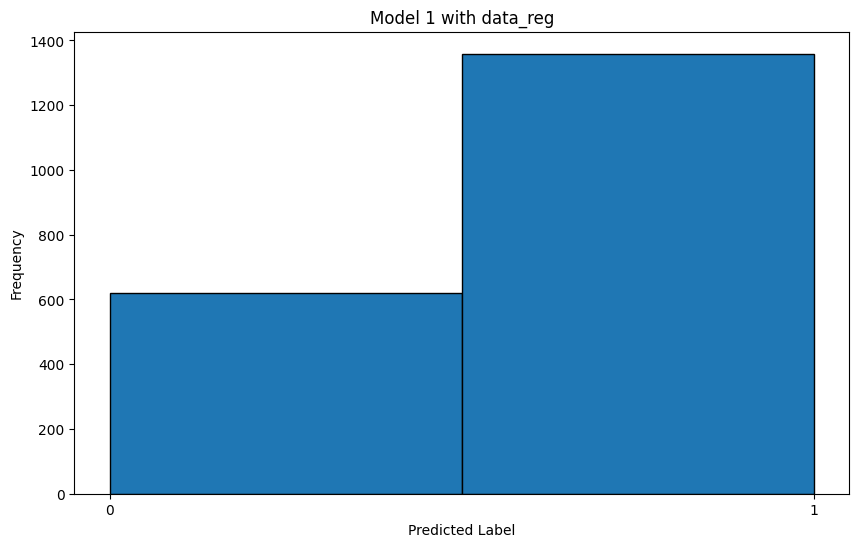

63/63 [==============================] - 0s 2ms/step


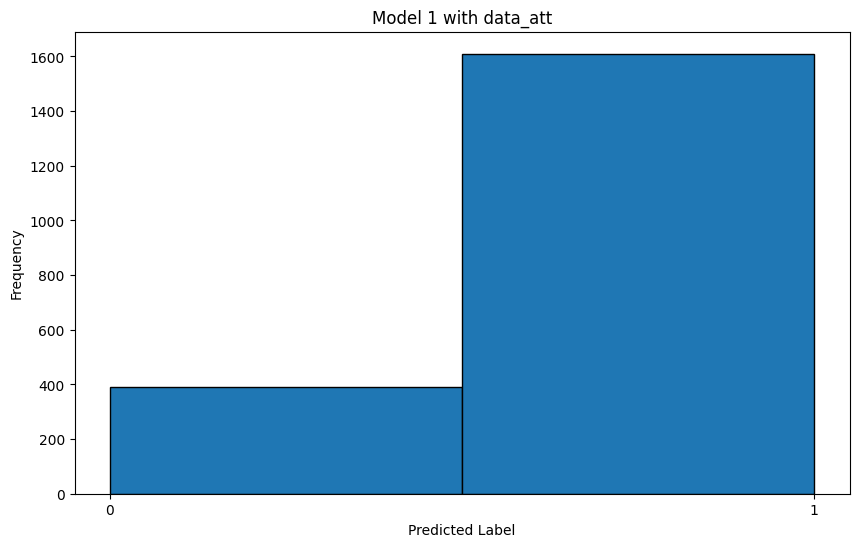

62/62 [==============================] - 0s 2ms/step


2024-06-05 12:27:24.146251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


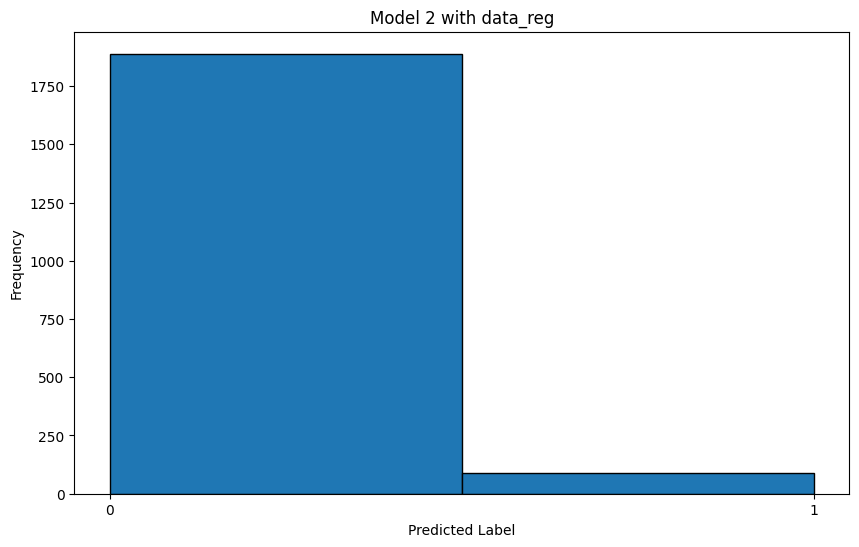

63/63 [==============================] - 0s 2ms/step


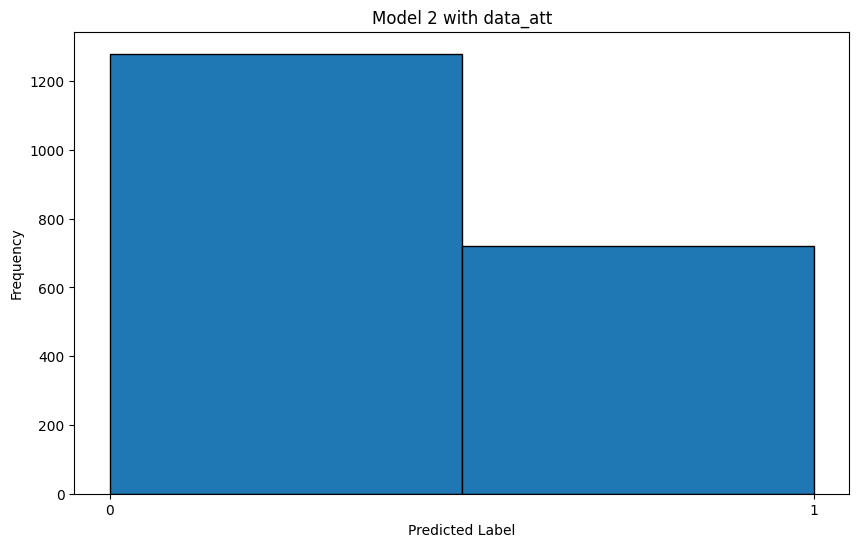

62/62 [==============================] - 0s 2ms/step


2024-06-05 12:27:24.644785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


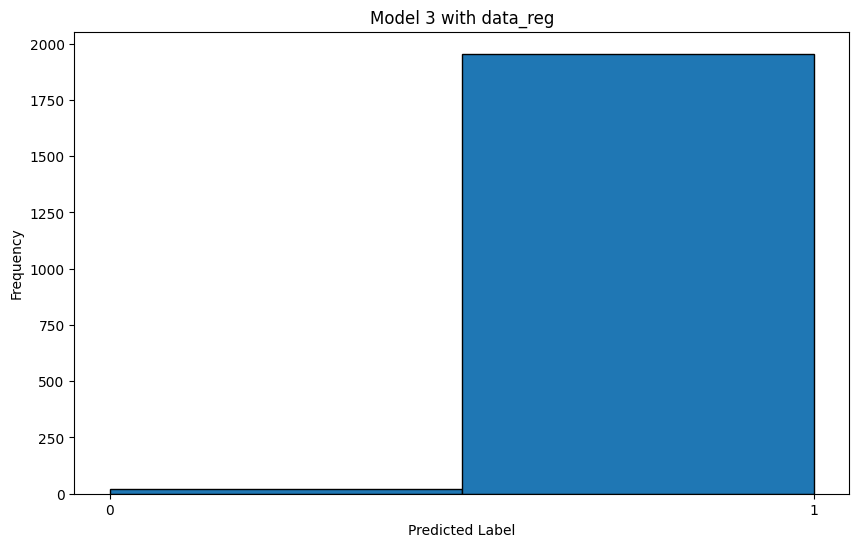

63/63 [==============================] - 0s 2ms/step


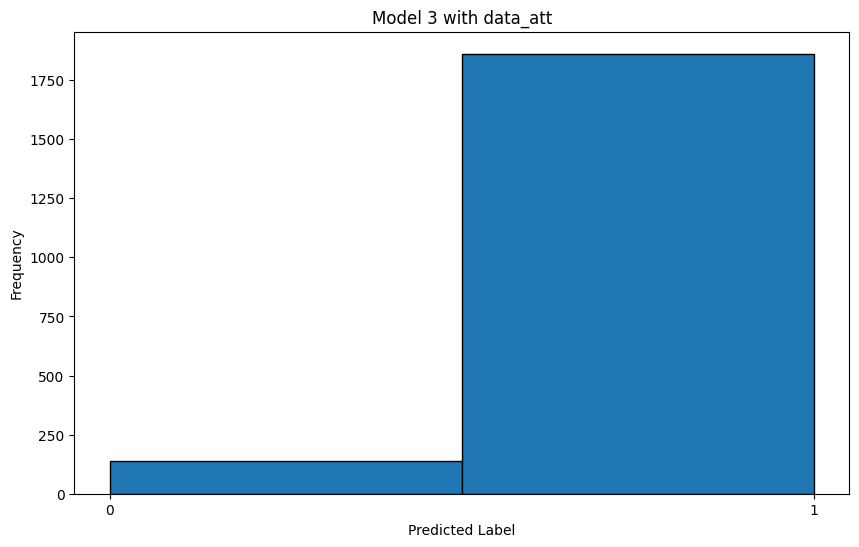

30/62 [=============>................] - ETA: 0s

2024-06-05 12:27:25.162652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


62/62 [==============================] - 0s 7ms/step


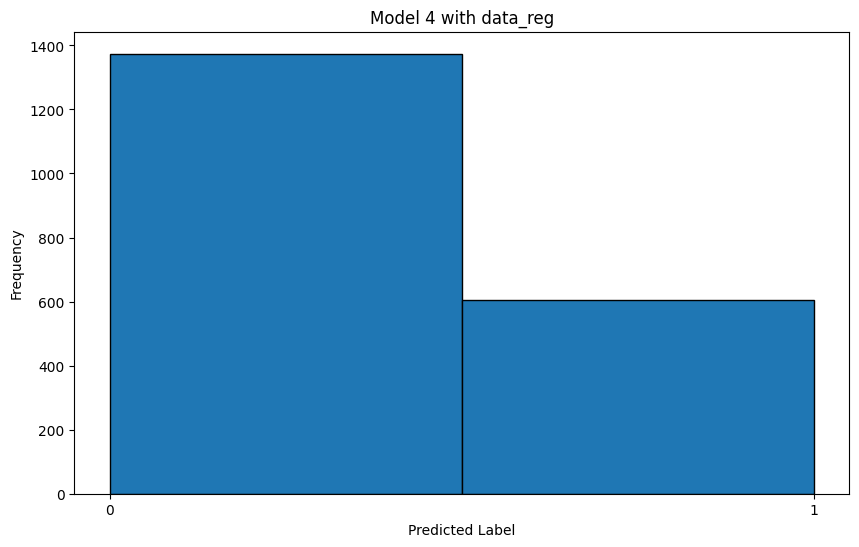

63/63 [==============================] - 0s 3ms/step


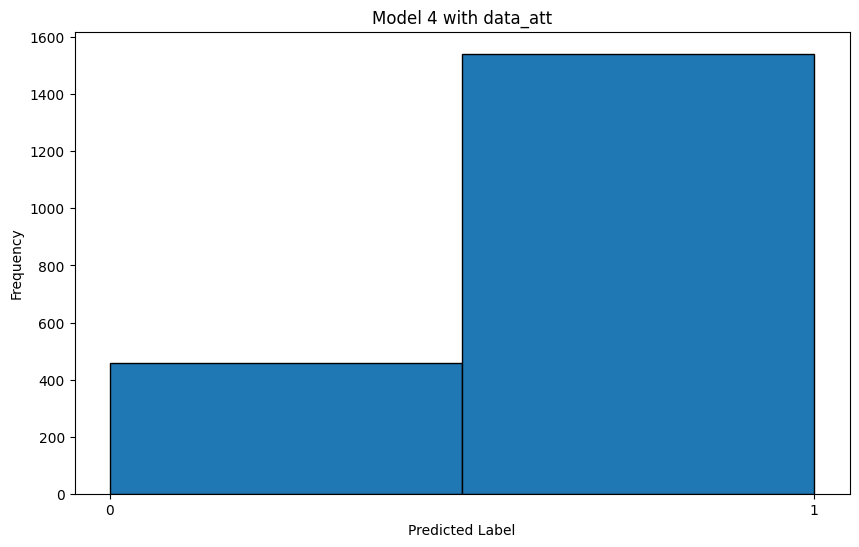

62/62 [==============================] - 0s 2ms/step


2024-06-05 12:27:25.967254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


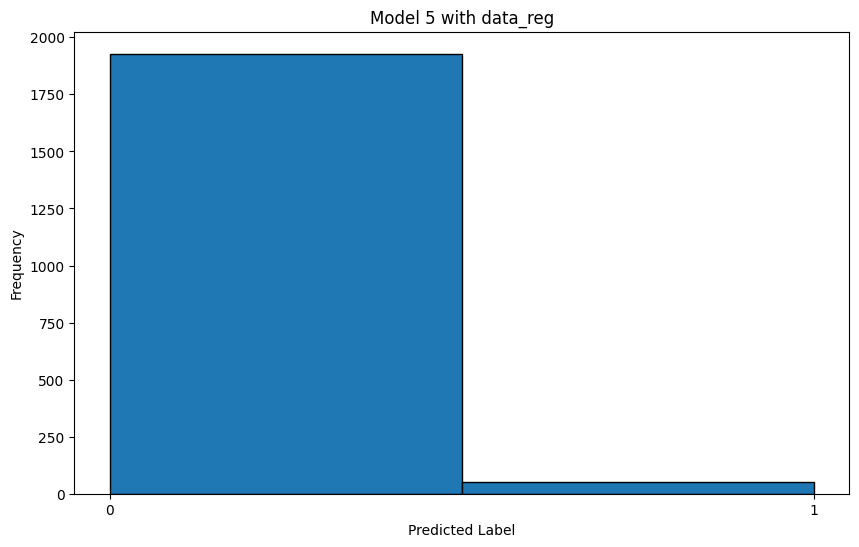

63/63 [==============================] - 0s 3ms/step


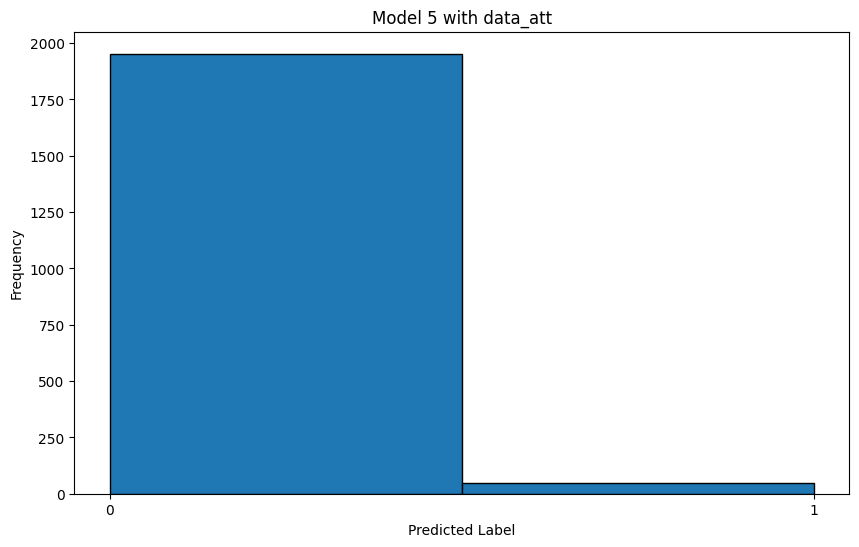

In [30]:
# Load the new models
models = [tf.keras.models.load_model(f'models/cnn_model_{i+1}.keras') for i in range(5)]

# Function to plot histograms
def plot_histogram(predicted_labels, title):
    plt.figure(figsize=(10, 6))
    plt.hist(predicted_labels, bins=2, edgecolor='black')
    plt.xlabel('Predicted Label')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.xticks([0, 1])
    plt.show()

# Function to make predictions and plot histograms
def evaluate_and_plot(model, data, title):
    predictions = model.predict(data)
    predicted_labels = (predictions > 0.5).astype(int)
    plot_histogram(predicted_labels, title)

# Iterate over each model and each dataset to generate plots
for i, model in enumerate(models):
    evaluate_and_plot(model, data_reg_reshaped, f'Model {i+1} with data_reg')
    evaluate_and_plot(model, data_att_reshaped, f'Model {i+1} with data_att')


In [26]:
from sklearn.metrics import classification_report

models = [tf.keras.models.load_model(f'models/cnn_model_{i+1}.keras') for i in range(5)]

# Function to evaluate models using classification report
def evaluate_model(model, data, title):
    predictions = model.predict(data)
    predicted_labels = (predictions > 0.5).astype(int)
    print(f"Evaluation for {title}:")
    print(classification_report(y_test, predicted_labels))

# Evaluate each model
for i, model in enumerate(models):
    evaluate_model(model, X_test_reshaped, f'Model {i+1}')


119/802 [===>..........................] - ETA: 0s

2024-06-05 12:11:35.417241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


802/802 [==============================] - 1s 1ms/step
Evaluation for Model 1:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9908
         1.0       1.00      1.00      1.00     15756

    accuracy                           1.00     25664
   macro avg       1.00      1.00      1.00     25664
weighted avg       1.00      1.00      1.00     25664

117/802 [===>..........................] - ETA: 0s

2024-06-05 12:11:36.605802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


802/802 [==============================] - 1s 1ms/step
Evaluation for Model 2:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9908
         1.0       1.00      1.00      1.00     15756

    accuracy                           1.00     25664
   macro avg       1.00      1.00      1.00     25664
weighted avg       1.00      1.00      1.00     25664

117/802 [===>..........................] - ETA: 0s

2024-06-05 12:11:37.761438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


802/802 [==============================] - 1s 1ms/step
Evaluation for Model 3:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9908
         1.0       1.00      1.00      1.00     15756

    accuracy                           1.00     25664
   macro avg       1.00      1.00      1.00     25664
weighted avg       1.00      1.00      1.00     25664

 97/802 [==>...........................] - ETA: 1s

2024-06-05 12:11:38.915413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


802/802 [==============================] - 1s 2ms/step
Evaluation for Model 4:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9908
         1.0       1.00      1.00      1.00     15756

    accuracy                           1.00     25664
   macro avg       1.00      1.00      1.00     25664
weighted avg       1.00      1.00      1.00     25664

112/802 [===>..........................] - ETA: 0s

2024-06-05 12:11:40.288874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


802/802 [==============================] - 1s 1ms/step
Evaluation for Model 5:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9908
         1.0       1.00      1.00      1.00     15756

    accuracy                           1.00     25664
   macro avg       1.00      1.00      1.00     25664
weighted avg       1.00      1.00      1.00     25664



In [33]:
%load_ext tensorboard

In [18]:
model = tf.keras.models.load_model('cnn_model_4.keras')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 18, 1, 32)         128       
                                                                 
 average_pooling2d_2 (Averag  (None, 9, 1, 32)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 1, 64)          6208      
                                                                 
 average_pooling2d_3 (Averag  (None, 3, 1, 64)         0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 192)               0         
                                                                 
 dense_2 (Dense)             (None, 128)              